#Grab the data

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
project_path = '/content/MyDrive/My Drive/Colab Notebooks/'
training_zip_path = project_path + 'face-mask-detector.zip'
from zipfile import ZipFile

with ZipFile(training_zip_path, 'r') as z:
  z.extractall()
print("Training zip extraction done!")

Training zip extraction done!


In [ ]:
%cd /content/face-mask-detector


/content/face-mask-detector


In [ ]:
!ls

dataset		      examples		   plot.png
detect_mask_image.py  face_detector	   train_mask_detector.py
detect_mask_video.py  mask_detector.model


In [ ]:
%cd /content/face-mask-detector/dataset/with_mask

/content/face-mask-detector/dataset/with_mask


In [ ]:
!ls -l | wc -l

691


In [ ]:
%cd /content/face-mask-detector/dataset/without_mask

/content/face-mask-detector/dataset/without_mask


In [ ]:
!ls -l | wc -l

687


In [ ]:
!rm mask_detector.model

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
plotImages(trainX)
print(labels)

NameError: ignored

#Data Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
imagePaths = list(paths.list_images('/content/face-mask-detector/dataset'))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:

	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

#2 conv layers only

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

In [ ]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=10, callbacks=[MCP, RLP]
)

Epoch 1/10
34/34 [==============================] - 12s 325ms/step - loss: 28.1190 - accuracy: 0.5090 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00001: val_accuracy did not improve from 1.00000
Epoch 2/10
34/34 [==============================] - 11s 309ms/step - loss: 0.6930 - accuracy: 0.5205 - val_loss: 0.6931 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 1.00000
Epoch 3/10
34/34 [==============================] - 10s 305ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 1.00000
Epoch 4/10
34/34 [==============================] - 10s 313ms/step - loss: 0.6931 - accuracy: 0.5092 - val_loss: 0.6934 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 1.00000
Epoch 5/10
34/34 [==============================] - 10s 308ms/step - loss: 0.6929 - accuracy: 0.5097 - val_loss: 0.6934 - val_accuracy: 0.5000

Epoch 00005: val_accuracy did not improve from 1.00000
Epoc

In [ ]:
# make predictions on the testing set
from sklearn.metrics import classification_report , confusion_matrix

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
print(confusion_matrix(testY.argmax(axis=1), predIdxs))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.00      0.00      0.00       138
without_mask       0.50      1.00      0.67       138

    accuracy                           0.50       276
   macro avg       0.25      0.50      0.33       276
weighted avg       0.25      0.50      0.33       276

[[  0 138]
 [  0 138]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#DenseNet


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
MCP = ModelCheckpoint('Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights=True,patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=4,factor=0.2,min_lr=0.001)

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121
dns = DenseNet121(weights='imagenet')

33193984/33188688 [==============================] - 1s 0us/step


In [ ]:
dns.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
pip install keras-tuner

     |████████████████████████████████| 71kB 5.1MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=57cbeb067a5d16ec9202442d16fdb532f9a846988f7f70eca89f861ca04adc57
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=c35d7bb402d23f01270ad1a99936bc0729d382b9f480fcc642453618870aa02f
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.python.keras import regularizers
x = dns.layers[-1].output
x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
output = Dense(2, 'softmax')(x)

model = Model(inputs=dns.inputs, outputs=output)

for layer in model.layers[:-1]:
  layer.trainable = False

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=20, callbacks=[MCP, RLP])


Epoch 1/20
34/34 [==============================] - 23s 469ms/step - loss: 449.1032 - accuracy: 0.7667 - val_loss: 449.0197 - val_accuracy: 0.9384

Epoch 00001: val_accuracy improved from -inf to 0.93841, saving model to Best_points.h5
Epoch 2/20
34/34 [==============================] - 12s 366ms/step - loss: 449.0105 - accuracy: 0.9273 - val_loss: 448.9480 - val_accuracy: 0.9457

Epoch 00002: val_accuracy improved from 0.93841 to 0.94565, saving model to Best_points.h5
Epoch 3/20
34/34 [==============================] - 13s 367ms/step - loss: 448.9542 - accuracy: 0.9608 - val_loss: 448.8978 - val_accuracy: 0.9638

Epoch 00003: val_accuracy improved from 0.94565 to 0.96377, saving model to Best_points.h5
Epoch 4/20
34/34 [==============================] - 13s 370ms/step - loss: 448.8991 - accuracy: 0.9557 - val_loss: 448.8592 - val_accuracy: 0.9674

Epoch 00004: val_accuracy improved from 0.96377 to 0.96739, saving model to Best_points.h5
Epoch 5/20
34/34 [=============================

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import classification_report , confusion_matrix

predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
print(confusion_matrix(testY.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

   with_mask       1.00      0.93      0.96       138
without_mask       0.93      1.00      0.97       138

    accuracy                           0.96       276
   macro avg       0.97      0.96      0.96       276
weighted avg       0.97      0.96      0.96       276

[[128  10]
 [  0 138]]


In [ ]:
import pandas as pd
testY = np.argmax(testY, axis=-1)
tdf = pd.DataFrame(testY)
predf = pd.DataFrame(predIdxs)
result = pd.concat([tdf, predf], axis=1)


In [ ]:
result.columns = ['y_true', 'predictions']

false_positive = result[(result.y_true == 0) & (result.predictions == 1)]
false_negative = result[(result.y_true == 1) & (result.predictions == 0)]

In [ ]:
false_positive

,y_true,predictions
8,0,1
60,0,1
98,0,1
141,0,1
156,0,1
224,0,1
261,0,1
263,0,1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


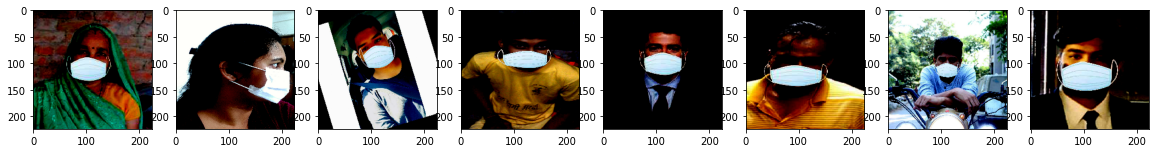

In [ ]:
plt.figure(figsize=(20,5))


for i in range(len(false_positive)):
  plt.subplot(1,len(false_positive),i+1)
  plt.imshow(testX[false_positive.index[i]])
  

In [ ]:
false_negative

,y_true,predictions
157,1,0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


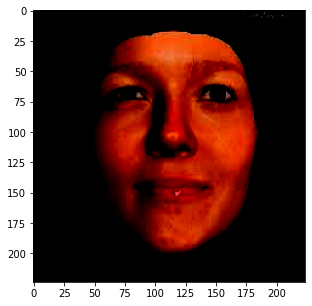

In [ ]:
plt.figure(figsize=(20,5))

for i in range(len(false_negative)):
  plt.subplot(1,len(false_negative),i+1)
  plt.imshow(testX[false_negative.index[i]])
  

#MovileNet Version2

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = 'nadam'
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=20, callbacks=[MCP, RLP])



9412608/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
[INFO] training head...
Epoch 1/20
34/34 [==============================] - 15s 359ms/step - loss: 0.3077 - accuracy: 0.8764 - val_loss: 0.0191 - val_accuracy: 0.9964

Epoch 00001: val_accuracy improved from 0.97101 to 0.99638, saving model to Best_points.h5
Epoch 2/20
34/34 [==============================] - 11s 320ms/step - loss: 0.0315 - accuracy: 0.9941 - val_loss: 0.0128 - val_accuracy: 0.9964

Epoch 00002: val_accuracy did not improve from 0.99638
Epoch 3/20
34/34 [==============================] - 11s 319ms/step - loss: 0.0203 - accuracy: 0.9956 - val_loss: 0.0099 - val_accuracy: 1.0000

Epoch 00003: val_accuracy improved from 0.99638 to 1.00000, saving model to Best_points.h5
Epoch 4/20
34/34 [==============================] - 11s 317ms/step - loss: 0.0191 - accuracy: 0.9953 - val_loss: 0.0103 - val_accuracy: 1.0000

Epoch 00004: val_accuracy did not improve from 1.00000
Epoch 5/20
34/34 [=

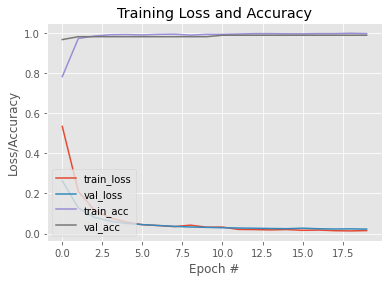

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
# make predictions on the testing set
from sklearn.metrics import classification_report , confusion_matrix

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
print(confusion_matrix(testY.argmax(axis=1), predIdxs))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       1.00      0.98      0.99       138
without_mask       0.98      1.00      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276

[[135   3]
 [  0 138]]


In [ ]:
predIdxs

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0])

In [ ]:
testY = np.argmax(testY, axis=-1)
testY

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0])

In [ ]:
import pandas as pd
tdf = pd.DataFrame(testY)
predf = pd.DataFrame(predIdxs)
result = pd.concat([tdf, predf], axis=1)
result.columns = ['y_true', 'predictions']

false_positive = result[(result.y_true == 0) & (result.predictions == 1)]
false_negative = result[(result.y_true == 1) & (result.predictions == 0)]

In [ ]:
false_positive

,y_true,predictions


In [ ]:
false_negative

,y_true,predictions
11,1,0
67,1,0
234,1,0
244,1,0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


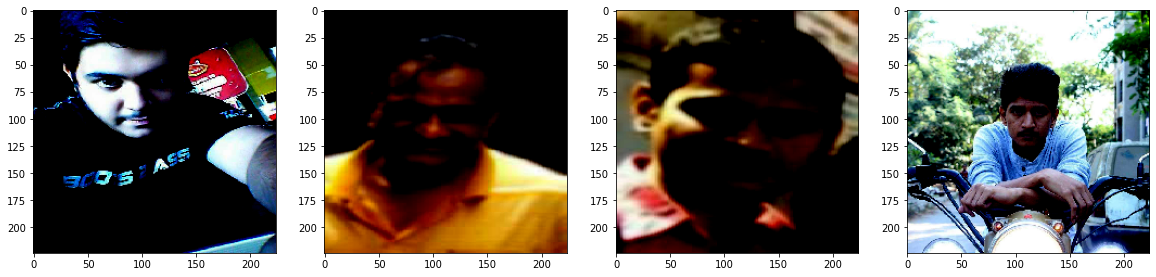

In [ ]:
plt.figure(figsize=(20,5))


plt.subplot(1,4,1)
plt.imshow(testX[11])

plt.subplot(1,4,2)
plt.imshow(testX[67])

plt.subplot(1,4,3)
plt.imshow(testX[234])

plt.subplot(1,4,4)
plt.imshow(testX[244])

#VGG-16

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
MCP = ModelCheckpoint('Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights=True,patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=4,factor=0.2,min_lr=0.001)

In [ ]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [ ]:
for layer in model.layers:
    layer.trainable = False
model.add(Dense(units=2, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=20, callbacks=[MCP, RLP])

Epoch 1/20
34/34 [==============================] - 14s 388ms/step - loss: 5.4077 - accuracy: 0.6024 - val_loss: 0.1738 - val_accuracy: 0.9420

Epoch 00001: val_accuracy improved from -inf to 0.94203, saving model to Best_points.h5
Epoch 2/20
34/34 [==============================] - 13s 375ms/step - loss: 0.1708 - accuracy: 0.9351 - val_loss: 0.0812 - val_accuracy: 0.9674

Epoch 00002: val_accuracy improved from 0.94203 to 0.96739, saving model to Best_points.h5
Epoch 3/20
34/34 [==============================] - 13s 373ms/step - loss: 0.1131 - accuracy: 0.9608 - val_loss: 0.0336 - val_accuracy: 0.9855

Epoch 00003: val_accuracy improved from 0.96739 to 0.98551, saving model to Best_points.h5
Epoch 4/20
34/34 [==============================] - 13s 376ms/step - loss: 0.0497 - accuracy: 0.9813 - val_loss: 0.0195 - val_accuracy: 0.9928

Epoch 00004: val_accuracy improved from 0.98551 to 0.99275, saving model to Best_points.h5
Epoch 5/20
34/34 [==============================] - 13s 383ms/s

In [ ]:
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
print(confusion_matrix(testY.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276

[[138   0]
 [  0 138]]


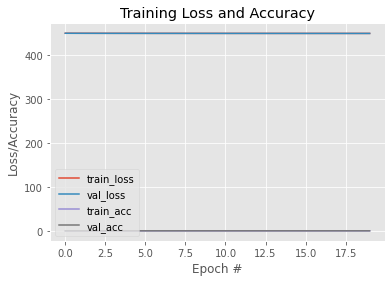

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

#Real-Time Detection (video)

In [ ]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

faceNet=cv2.dnn.readNet('/content/face-mask-detector/face_detector/deploy.prototxt','/content/face-mask-detector/face_detector/res10_300x300_ssd_iter_140000.caffemodel')

In [ ]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [ ]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam
    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)

    return image_array

<IPython.core.display.Javascript object>

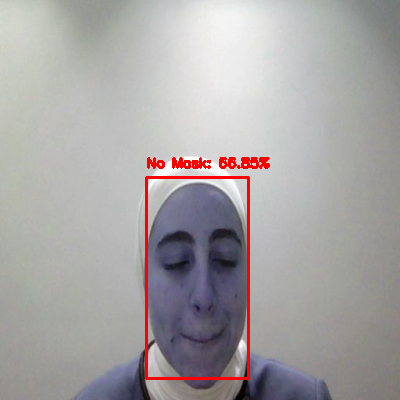

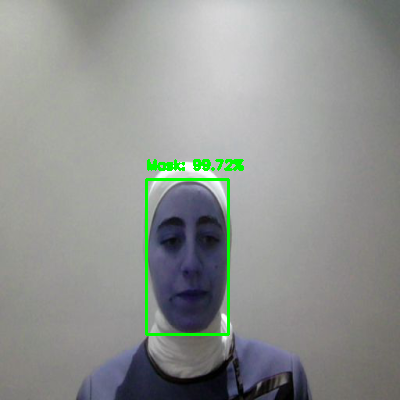

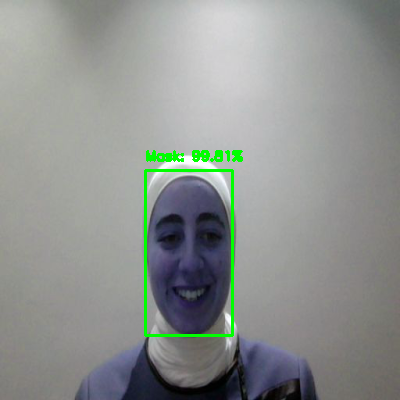

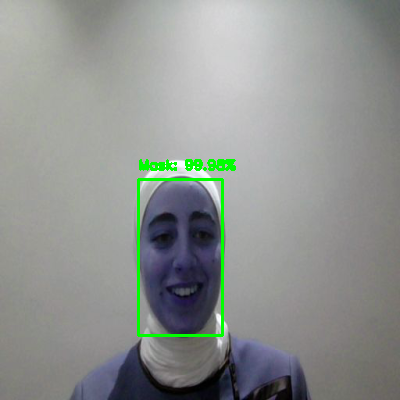

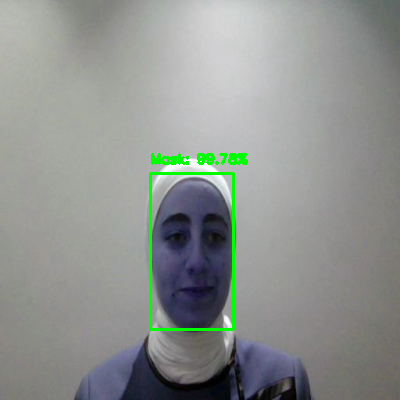

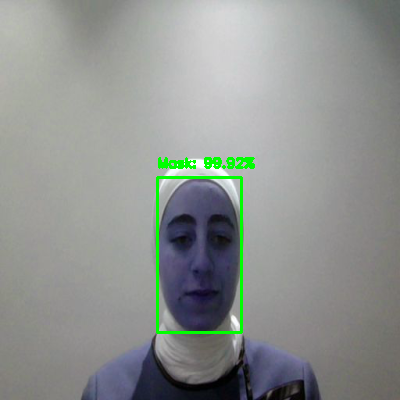

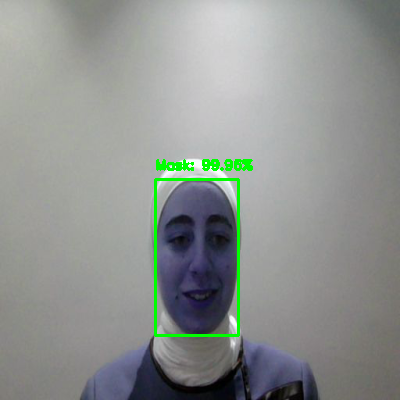

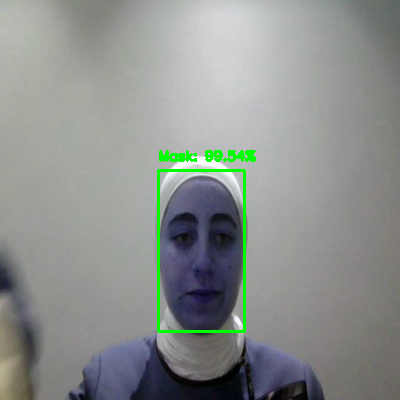

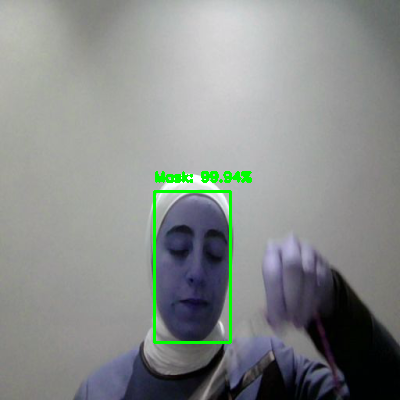

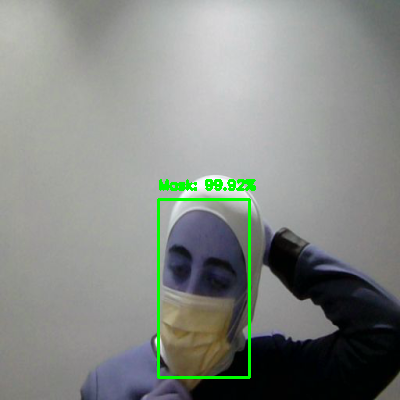

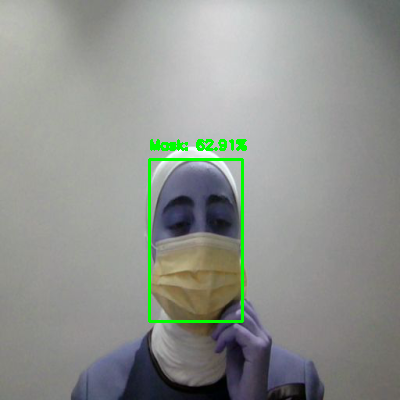

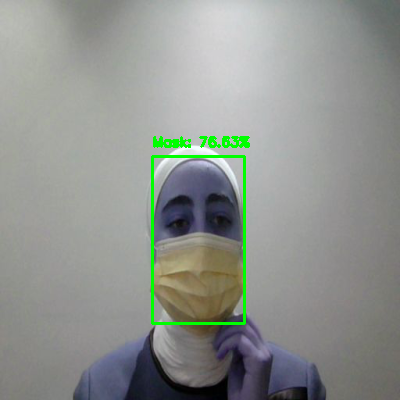

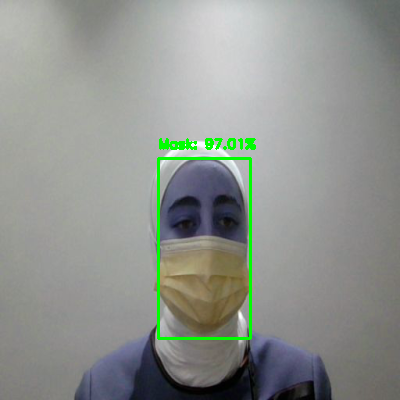

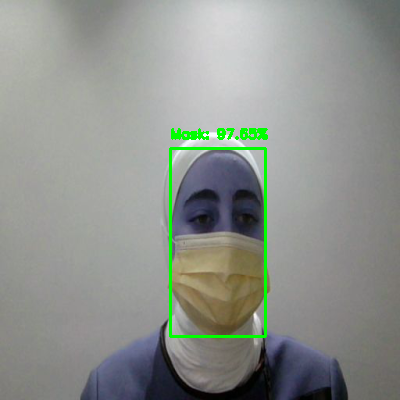

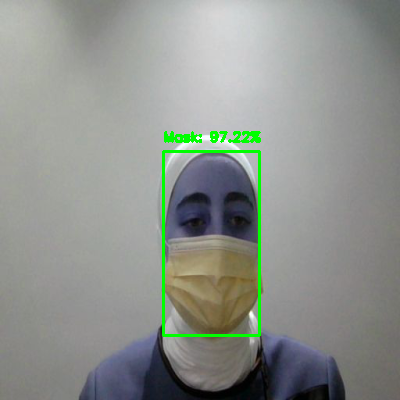

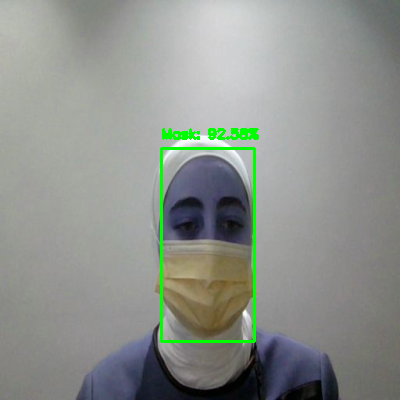

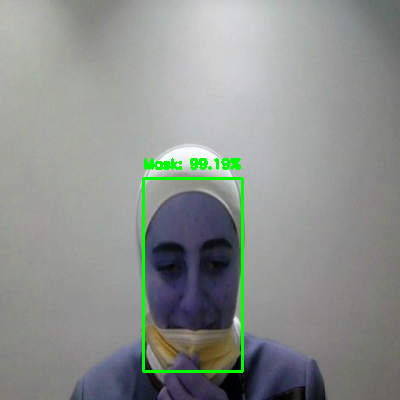

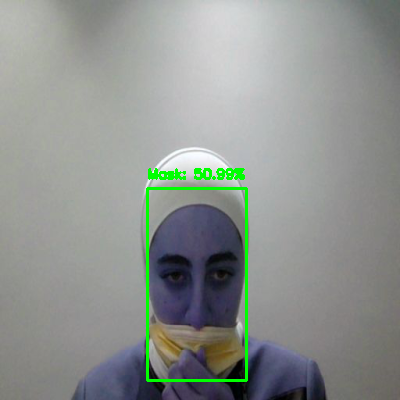

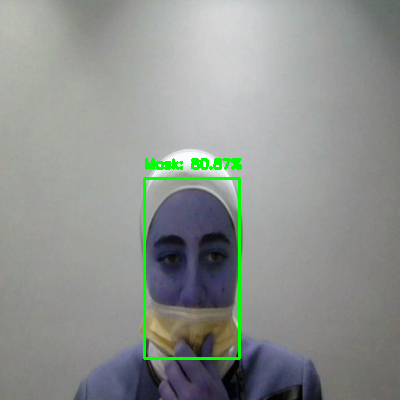

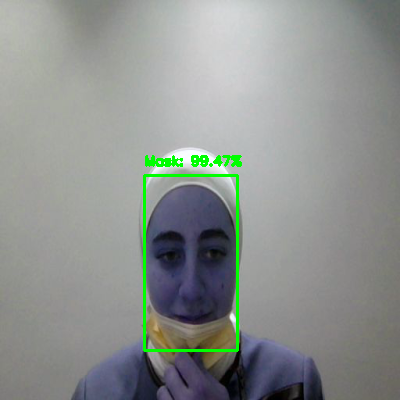

In [ ]:
import imutils
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 
from google.colab.patches import cv2_imshow
while True:
  js_reply = take_photo(label_html, img_data)
  if not js_reply:
    break
    
  image = js_reply_to_image(js_reply)

	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
  frame = image
  v=True
  if v == True:

    frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a
	# face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, model)
    for (box, pred) in zip(locs, preds):


		# unpack the bounding box and predictions
      (startX, startY, endX, endY) = box
      (mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
      frame=cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      frame=cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
      cv2_imshow(frame)